# SVHN Project

- Using SVHN as an example, using deep learning how to implement a project completely. In this project I as far as possible implement this project based on all mastered knowledge. 

- Although building the project maybe too complex, based on aim of learning and showing, i still add more and more steps in this project.

## Import libraries

In [1]:
import gc  # garbage collector
import random
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from torch.utils.data import DataLoader
from torchvision import models as m
from torchvision import transforms as T
from torch.nn import functional as F
from torch import nn, optim
import torchvision
import os
import torch
# Used to avoid sudden shutdown of the jupyter environment
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.backends.cudnn.benchmark = True  # Code for accelerating GPU operations

In [2]:
torch.manual_seed(1412)
random.seed(1412)
np.random.seed(1412)

In [4]:
# checking devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Generate data and Process data

In [5]:
# load train dataset
train = torchvision.datasets.SVHN(root=r"E:\data\SVHN\SVHN", split="train", download=False, transform=T.ToTensor()
                                  )

In [6]:
train[6][0]

tensor([[[0.3255, 0.3294, 0.3294,  ..., 0.5843, 0.5882, 0.5961],
         [0.3373, 0.3333, 0.3294,  ..., 0.5882, 0.5686, 0.5725],
         [0.3451, 0.3373, 0.3255,  ..., 0.5490, 0.5294, 0.5294],
         ...,
         [0.3373, 0.3137, 0.3216,  ..., 0.2235, 0.2588, 0.2667],
         [0.3412, 0.3137, 0.3255,  ..., 0.2510, 0.3020, 0.3059],
         [0.3373, 0.3176, 0.3216,  ..., 0.2667, 0.3294, 0.3255]],

        [[0.2667, 0.2706, 0.2706,  ..., 0.5529, 0.5529, 0.5608],
         [0.2784, 0.2745, 0.2706,  ..., 0.5608, 0.5451, 0.5490],
         [0.2863, 0.2784, 0.2667,  ..., 0.5255, 0.5098, 0.5098],
         ...,
         [0.2784, 0.2549, 0.2588,  ..., 0.2431, 0.2784, 0.2941],
         [0.2824, 0.2510, 0.2627,  ..., 0.2627, 0.3137, 0.3255],
         [0.2784, 0.2549, 0.2588,  ..., 0.2745, 0.3412, 0.3451]],

        [[0.1843, 0.1804, 0.1882,  ..., 0.5098, 0.5176, 0.5255],
         [0.1882, 0.1843, 0.1882,  ..., 0.5216, 0.5137, 0.5176],
         [0.1961, 0.1882, 0.1843,  ..., 0.5059, 0.4980, 0.

In [7]:
# load test dataset
test = torchvision.datasets.SVHN(
    root=r"E:\data\SVHN\SVHN", split="test", download=False, transform=T.ToTensor())

In [8]:
train

Dataset SVHN
    Number of datapoints: 73257
    Root location: E:\data\SVHN\SVHN
    Split: train
    StandardTransform
Transform: ToTensor()

In [9]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: E:\data\SVHN\SVHN
    Split: test
    StandardTransform
Transform: ToTensor()

In [10]:
# Let each data set display 5 images at random
def plotsample(data):  # 只能够接受tensor格式的图像
    fig, axs = plt.subplots(1, 5, figsize=(10, 10))  # 建立子图
    for i in range(5):
        num = random.randint(0, len(data)-1)  # 首先选取随机数，随机选取五次
        # 抽取数据中对应的图像对象，make_grid函数可将任意格式的图像的通道数升为3，而不改变图像原始的数据
        # 而展示图像用的imshow函数最常见的输入格式也是3通道
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1]  # 提取标签
        # 将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
        axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[i].set_title(nplabel)  # 给每个子图加上标签
        axs[i].axis("off")  # 消除每个子图的坐标轴

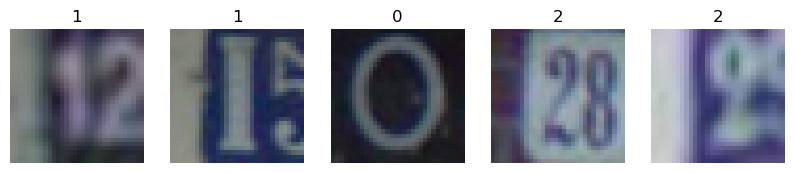

In [11]:
plotsample(train)

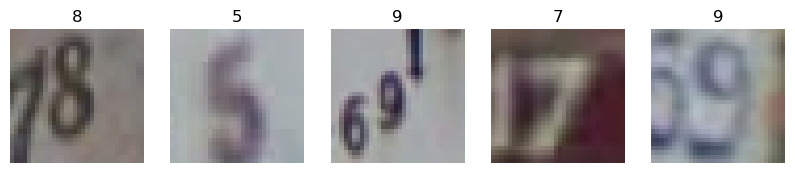

In [12]:
plotsample(test)

In [13]:
# Augmentation train data
trainT = T.Compose([T.RandomCrop(28), T.RandomRotation(degrees=[-30, 30]), T.ToTensor(),
                   T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [14]:
# Augmentation test data
testT = T.Compose([T.CenterCrop(28), T.ToTensor(), T.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [15]:
train = torchvision.datasets.SVHN(root=r"E:\data\SVHN\SVHN", split="train", download=False, transform=trainT
                                  )

In [16]:
test = torchvision.datasets.SVHN(root=r"E:\data\SVHN\SVHN", split="test", download=False, transform=testT
                                 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


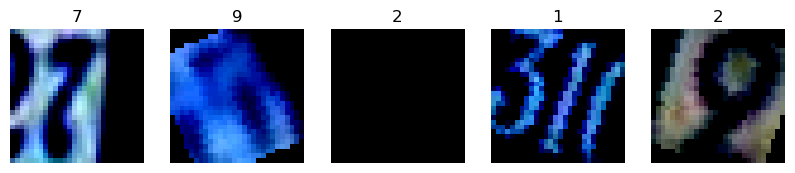

In [17]:
plotsample(train)

## Building Models

- Due to small dataset (Comparatively shallow, overall low number of participants)
- I choose ResNet18, VGG16

In [18]:
torch.manual_seed(1412)
resnet18_ = m.resnet18()
vgg16_ = m.vgg16()  # VGG本来参数量就很大，因此我个人较少使用vgg16_bn

In [19]:
resnet18_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False), resnet18_.bn1, resnet18_.relu)  # 删除池化层

        # 后续的架构直接从经典架构中选
        # 对尺寸很小的数据集而言，我们的深度本来就不深，因此可以试着在特征图数量上有所增加（增加宽度）
        self.block2 = resnet18_.layer2  # 2个残差单元
        self.block3 = resnet18_.layer3  # 2个残差单元
        # 自适应平均池化+线性层，此处都与残差网络一致
        self.avgpool = resnet18_.avgpool
        # 输出的线性层自己写，以确保输出的类别数量正确
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], 256)
        x = self.fc(x)
        return x

In [21]:
vgg16_

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
class MyVgg(nn.Module):
    def __init__(self):
        super().__init__()

        # 在9层之后增加一个单独的卷积层，再加入池化层，构成(卷积x2+池化) + (卷积x3+池化)的类似AlexNet的结构
        self.features = nn.Sequential(*vgg16_.features[0:9]  # 星号用于解码
                                      , nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2, padding=0, dilation=1, ceil_mode=False))
        # 进入线性层时输入通道数发生变化，因此线性层需要重写
        # 输出层也需要重写
        self.avgpool = vgg16_.avgpool
        self.fc = nn.Sequential(nn.Linear(7*7*128, out_features=4096, bias=True), *
                                vgg16_.classifier[1:6], nn.Linear(in_features=4096, out_features=10, bias=True))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], 7*7*128)
        x = self.fc(x)
        return x

In [23]:
from torchinfo import summary

In [24]:
summary(MyResNet(), (10, 3, 28, 28), depth=2, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10]          

In [25]:
summary(MyVgg(), (10, 3, 28, 28), depth=2, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyVgg                                    [10, 10]                  --
├─Sequential: 1-1                        [10, 128, 7, 7]           --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,792
│    └─ReLU: 2-2                         [10, 64, 28, 28]          --
│    └─Conv2d: 2-3                       [10, 64, 28, 28]          36,928
│    └─ReLU: 2-4                         [10, 64, 28, 28]          --
│    └─MaxPool2d: 2-5                    [10, 64, 14, 14]          --
│    └─Conv2d: 2-6                       [10, 128, 14, 14]         73,856
│    └─ReLU: 2-7                         [10, 128, 14, 14]         --
│    └─Conv2d: 2-8                       [10, 128, 14, 14]         147,584
│    └─ReLU: 2-9                         [10, 128, 14, 14]         --
│    └─Conv2d: 2-10                      [10, 128, 14, 14]         147,584
│    └─ReLU: 2-11                        [10, 128, 14, 14]      

In [26]:
[*MyResNet().block2[0].parameters()][0][0][0]

tensor([[ 0.0324, -0.0175,  0.0459],
        [ 0.0728, -0.0392,  0.0903],
        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward>)

In [27]:
[*resnet18_.layer2[0].conv1.parameters()][0][0][0]

tensor([[ 0.0324, -0.0175,  0.0459],
        [ 0.0728, -0.0392,  0.0903],
        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward>)

In [28]:
[*resnet18_.fc.parameters()]  # 自己设立的部分参数是不同的
[*MyResNet().fc.parameters()]

[Parameter containing:
 tensor([[ 0.0218, -0.0385, -0.0548,  ...,  0.0045, -0.0612,  0.0406],
         [-0.0398,  0.0063,  0.0567,  ..., -0.0390,  0.0392, -0.0345],
         [-0.0231, -0.0487, -0.0456,  ..., -0.0538,  0.0066, -0.0088],
         ...,
         [ 0.0070, -0.0560, -0.0430,  ...,  0.0526, -0.0575,  0.0610],
         [-0.0354, -0.0283,  0.0108,  ..., -0.0044, -0.0565,  0.0460],
         [ 0.0033,  0.0593,  0.0278,  ..., -0.0409, -0.0437,  0.0202]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0122, -0.0585,  0.0398, -0.0387,  0.0612, -0.0471,  0.0494,  0.0117,
          0.0264,  0.0493], requires_grad=True)]

## Early stopping

In [29]:
class EarlyStopping():
    def __init__(self, patience=5, tol=0.0005):  # 惯例地定义我们所需要的一切变量/属性\
        # 当连续patience次迭代时，这一轮迭代的损失与历史最低损失之间的差值小于阈值时
        # 就触发提前停止

        self.patience = patience
        self.tol = tol  # tolerance，累积5次都低于tol才会触发停止
        self.counter = 0  # 计数，计算现在已经累积了counter次
        self.lowest_loss = None
        self.early_stop = False  # True - 提前停止，False - 不要提前停止

    def __call__(self, val_loss):
        if self.lowest_loss == None:  # 这是第一轮迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(
                self.counter, self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop

## Train

In [30]:
def IterOnce(net, criterion, opt, x, y):
    """
    对模型进行一次迭代的函数

    net: 实例化后的架构
    criterion: 损失函数
    opt: 优化算法
    x: 这一个batch中所有的样本
    y: 这一个batch中所有样本的真实标签
    """
    sigma = net.forward(x)
    loss = criterion(sigma, y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True)  # 比起设置梯度为0，让梯度为None会更节约内存
    yhat = torch.max(sigma, 1)[1]
    correct = torch.sum(yhat == y)
    return correct, loss

In [31]:
def TestOnce(net, criterion, x, y):
    """
    对一组数据进行测试并输出测试结果的函数

    net: 经过训练后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y：要测试的数据的真实标签
    """
    # 对测试，一定要阻止计算图追踪
    # 这样可以节省很多内存，加速运算
    with torch.no_grad():
        sigma = net.forward(x)
        loss = criterion(sigma, y)
        yhat = torch.max(sigma, 1)[1]
        correct = torch.sum(yhat == y)
    return correct, loss

In [32]:
def fit_test(net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH):
    """
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率/损失
    以实现对模型的监控
    实现模型的保存

    参数说明：
    net: 实例化后的网络
    batchdata：使用Dataloader分割后的训练数据
    testdata：使用Dataloader分割后的测试数据
    criterion：所使用的损失函数
    opt：所使用的优化算法
    epochs：一共要使用完整数据集epochs次
    tol：提前停止时测试集上loss下降的阈值，连续5次loss下降不超过tol就会触发提前停止
    modelname：现在正在运行的模型名称，用于保存权重时作为文件名
    PATH：将权重文件保存在path目录下

    """

    SamplePerEpoch = batchdata.dataset.__len__()  # 整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None

    for epoch in range(1, epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            y = y.view(x.shape[0])
            correct, loss = IterOnce(net, criterion, opt, x, y)
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct

            if (batch_idx+1) % 125 == 0:
                # 现在进行到了哪个epoch
                # 现在训练到了多少个样本
                # 总共要训练多少个样本
                # 现在的训练的样本占总共需要训练的样本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch,
                      trainedsamples, allsamples, 100*trainedsamples/allsamples))

        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch  # 平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)

        # 每次训练完一个epoch，就在测试集上验证一下模型现在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x, y in testdata:
            y = y.view(x.shape[0])
            correct, loss = TestOnce(net, criterion, x, y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)

        # 对每一个epoch，打印训练和测试的结果
        # 训练集上的损失，测试集上的损失，训练集上的准确率，测试集上的准确率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(
            TrainLossThisEpoch, TestLossThisEpoch, TrainAccThisEpoch, TestAccThisEpoch))

        # 如果测试集准确率出现新高/测试集loss出现新低，那我会保存现在的这一组权重
        if highestacc == None:  # 首次进行测试
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), os.path.join(PATH, modelname+".pt"))
            print("\t Weight Saved")

        # 提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break

    print("Complete")
    return trainlosslist, testlosslist

In [33]:
bs = 128
# net
lr = 0.001
alpha = 0.99
gamma = 0
wd = 0

In [34]:
batchdata = DataLoader(train, batch_size=bs, shuffle=True,
                       drop_last=False, num_workers=4)  # 线程 - 调度计算资源的最小单位
testdata = DataLoader(test, batch_size=bs, shuffle=False,
                      drop_last=False, num_workers=4)

In [36]:
def full_procedure(net, epochs, bs, modelname, PATH, lr=0.001, alpha=0.99, gamma=0, wd=0, tol=10**(-5)):

    torch.manual_seed(1412)

    # 分割数据
    batchdata = DataLoader(train, batch_size=bs, shuffle=True,
                           drop_last=False, num_workers=4)  # 线程 - 调度计算资源的最小单位
    testdata = DataLoader(test, batch_size=bs, shuffle=False,
                          drop_last=False, num_workers=4)

    # 损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum")  # 进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(), lr=lr, alpha=alpha,
                        momentum=gamma, weight_decay=wd)

    # 训练与测试
    trainloss, testloss = fit_test(
        net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH)

    return trainloss, testloss

In [37]:
# 绘图函数
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [38]:
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [39]:
torch.cuda.is_available()

True

In [40]:
def fit_test(net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH):
    """
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率/损失
    以实现对模型的监控
    实现模型的保存

    参数说明：
    net: 实例化后的网络
    batchdata：使用Dataloader分割后的训练数据
    testdata：使用Dataloader分割后的测试数据
    criterion：所使用的损失函数
    opt：所使用的优化算法
    epochs：一共要使用完整数据集epochs次
    tol：提前停止时测试集上loss下降的阈值，连续5次loss下降不超过tol就会触发提前停止
    modelname：现在正在运行的模型名称，用于保存权重时作为文件名
    PATH：将权重文件保存在path目录下

    """

    SamplePerEpoch = batchdata.dataset.__len__()  # 整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None

    for epoch in range(1, epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            # non_blocking 非阻塞 = True
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(x.shape[0])
            correct, loss = IterOnce(net, criterion, opt, x, y)

            # 计算样本总量、总的correct、loss
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct

            if (batch_idx+1) % 125 == 0:
                # 现在进行到了哪个epoch
                # 现在训练到了多少个样本
                # 总共要训练多少个样本
                # 现在的训练的样本占总共需要训练的样本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch,
                      trainedsamples, allsamples, 100*trainedsamples/allsamples))

        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch  # 平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)

        # 清理GPU内存
        # 清理掉一个epoch循环下面不再需要的中间变量
        del x, y, correct, loss, correct_train, loss_train  # 删除数据与变量
        gc.collect()  # 清除数据与变量相关的缓存
        torch.cuda.empty_cache()  # 缓存分配器分配出去的内存给释放掉

        # 每次训练完一个epoch，就在测试集上验证一下模型现在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x, y in testdata:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(x.shape[0])
            correct, loss = TestOnce(net, criterion, x, y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)

        # 清理GPU内存
        del x, y, correct, loss, correct_test, loss_test
        gc.collect()
        torch.cuda.empty_cache()

        # 对每一个epoch，打印训练和测试的结果
        # 训练集上的损失，测试集上的损失，训练集上的准确率，测试集上的准确率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(
            TrainLossThisEpoch, TestLossThisEpoch, TrainAccThisEpoch, TestAccThisEpoch))

        # 如果测试集准确率出现新高/测试集loss出现新低，那我会保存现在的这一组权重
        if highestacc == None:  # 首次进行测试
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), os.path.join(PATH, modelname+".pt"))
            print("\t Weight Saved")

        # 提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break

    print("Complete")
    return trainlosslist, testlosslist

In [41]:
torch.cuda.memory_allocated()  # 张量内存的占用情况（现状）
torch.cuda.memory_reserved()  # 缓存分配器占用的所有内存（现状）
torch.cuda.max_memory_allocated()  # 自GPU运行以来占用过的最大张量内存（峰值）

0

In [42]:
def full_procedure(net, epochs, bs, modelname, PATH, lr=0.001, alpha=0.99, gamma=0, wd=0, tol=10**(-5)):

    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    torch.manual_seed(1412)

    # 分割数据
    batchdata = DataLoader(train, batch_size=bs,
                           shuffle=True, drop_last=False, pin_memory=True)
    testdata = DataLoader(test, batch_size=bs, shuffle=False,
                          drop_last=False, pin_memory=True)

    # 损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum")  # 进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(), lr=lr, alpha=alpha,
                        momentum=gamma, weight_decay=wd)

    # 训练与测试
    trainloss, testloss = fit_test(
        net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH)

    return trainloss, testloss

## Model selection

In [43]:
from torchinfo import summary
for name, i in [("ResNet", MyResNet()), ("VGG", MyVgg())]:
    print("\n")
    print(name)
    print(summary(i, input_size=(10, 3, 28, 28), depth=2, device="cpu"))
    print("\n")



ResNet
Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10] 

In [47]:
# 建立目录用于存储模型选择结果
PATH = r"E:\data\SVHN\modelselect"

# 使用函数full_procedure中的默认参数，在模型选择时加入时间计算
# 基于现有显存，batch_size被设置为256，对于CPU而言最好从64开始设置
# MyResNet
avgtime = []  # 用来存放每次循环之后获得的训练时间
for i in range(5):  # 进行5次训练
    # 设置随机数种子
    torch.manual_seed(1412)

    # 实例化
    resnet18_ = m.resnet18()
    net = MyResNet().to(device, non_blocking=True)

    # 训练
    start = time()  # 计算训练时间
    trainloss, testloss = full_procedure(
        net, epochs=3, bs=256, modelname="model_seletion_resnet", PATH=PATH)
    avgtime.append(time()-start)

Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:151.085712, Test Loss:53.712210, Train Acc:47.845%, Test Acc:83.232%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:46.388410, Test Loss:31.574219, Train Acc:85.648%, Test Acc:90.592%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:36.437102, Test Loss:23.114417, Train Acc:88.772%, Test Acc:93.254%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:151.188596, Test Loss:52.909616, Train Acc:47.870%, Test Acc:83.501%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:46.099318, Test Loss:33.823237, Train Acc:85.629%, Test Acc:89.966%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:36.135011, Test Loss:23.919981, Train Acc:88.999%, Test Acc:93.143%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:152.416738, Test Loss:47.727369, Tr

In [48]:
print(np.mean(avgtime))

96.61155414581299


In [49]:
# MyVGG
avgtime = []
for i in range(5):
    torch.manual_seed(1412)
    vgg16_ = m.vgg16_bn()
    net = MyVgg().to(device, non_blocking=True)
    start = time()  # 计算训练时间
    # 此时使用的是full_procedure的默认参数
    trainloss, testloss = full_procedure(
        net, epochs=3, bs=256, modelname="model_seletion_vgg", PATH=PATH)
    avgtime.append(time()-start)

Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:2529.075665, Test Loss:217.989321, Train Acc:17.268%, Test Acc:22.008%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:211.358955, Test Loss:162.430509, Train Acc:24.060%, Test Acc:46.055%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:161.940552, Test Loss:88.383499, Train Acc:45.155%, Test Acc:75.200%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:2528.831920, Test Loss:216.557737, Train Acc:17.362%, Test Acc:22.726%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:211.596011, Test Loss:154.476442, Train Acc:23.800%, Test Acc:51.341%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:160.584449, Test Loss:89.549353, Train Acc:45.193%, Test Acc:73.152%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:2529.096632, Test Loss:21

In [50]:
del net
gc.collect()
torch.cuda.empty_cache()
print(np.mean(avgtime))

93.91382303237916


## Model Optimization

### Increasing iterate times

myResNet_test0
Epoch1:[32000/732570(4%)]
Epoch1:[64000/732570(9%)]
	 Train Loss:150.559714, Test Loss:54.995851, Train Acc:48.184%, Test Acc:82.637%
Epoch2:[105257/732570(14%)]
Epoch2:[137257/732570(19%)]
	 Train Loss:46.044170, Test Loss:32.469473, Train Acc:85.706%, Test Acc:90.058%
	 Weight Saved
Epoch3:[178514/732570(24%)]
Epoch3:[210514/732570(29%)]
	 Train Loss:36.169847, Test Loss:23.788594, Train Acc:88.927%, Test Acc:93.009%
	 Weight Saved
Epoch4:[251771/732570(34%)]
Epoch4:[283771/732570(39%)]
	 Train Loss:32.010849, Test Loss:22.015771, Train Acc:90.131%, Test Acc:93.742%
	 Weight Saved
Epoch5:[325028/732570(44%)]
Epoch5:[357028/732570(49%)]
	 Train Loss:29.320570, Test Loss:20.653448, Train Acc:91.165%, Test Acc:94.199%
	 Weight Saved
Epoch6:[398285/732570(54%)]
Epoch6:[430285/732570(59%)]
	 Train Loss:27.088585, Test Loss:19.320018, Train Acc:91.821%, Test Acc:94.653%
	 Weight Saved
Epoch7:[471542/732570(64%)]
Epoch7:[503542/732570(69%)]
	 Train Loss:25.694311, Test Loss:1

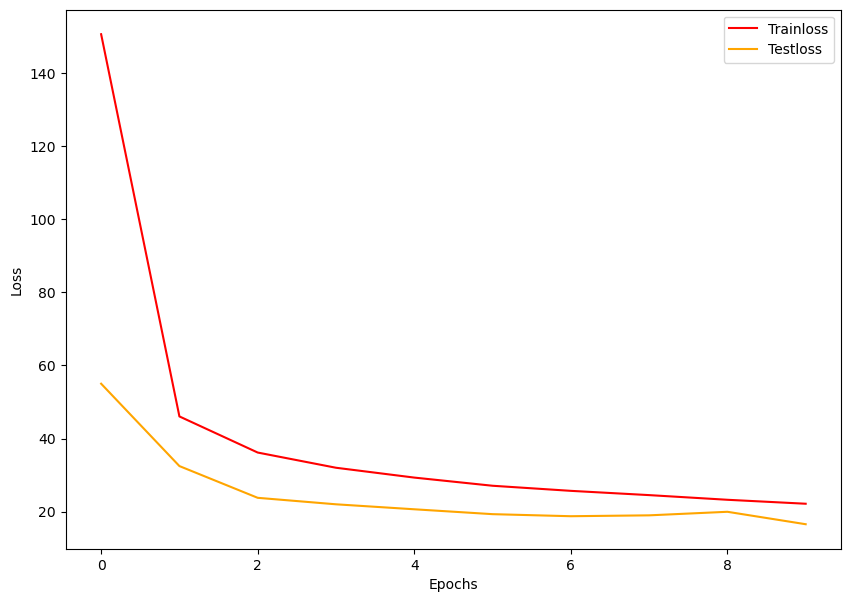

In [51]:
# 尝试增加到10个epochs
PATH = r"E:\data\SVHN\modelselect\ConfirmedResNet"
modelname = "myResNet_test0"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet().to(device, non_blocking=True)
start = time()  # 计算训练时间
trainloss, testloss = full_procedure(
    net, epochs=10, bs=256, modelname=modelname, PATH=PATH)
print(time()-start)
plotloss(trainloss, testloss)

MyResNet_test1
Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:149.926696, Test Loss:53.973187, Train Acc:48.326%, Test Acc:83.378%
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:45.880540, Test Loss:36.002696, Train Acc:85.783%, Test Acc:88.829%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:36.199032, Test Loss:25.954508, Train Acc:88.942%, Test Acc:92.221%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:32.094479, Test Loss:21.770773, Train Acc:90.117%, Test Acc:93.769%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:29.411080, Test Loss:24.179911, Train Acc:91.149%, Test Acc:92.720%
	 NOTICE: Early stopping counter 1 of 5
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:27.220943, Test Loss:19.061938, Train Acc:91.831%, Test Acc:94.733%
	 Weight Saved
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]

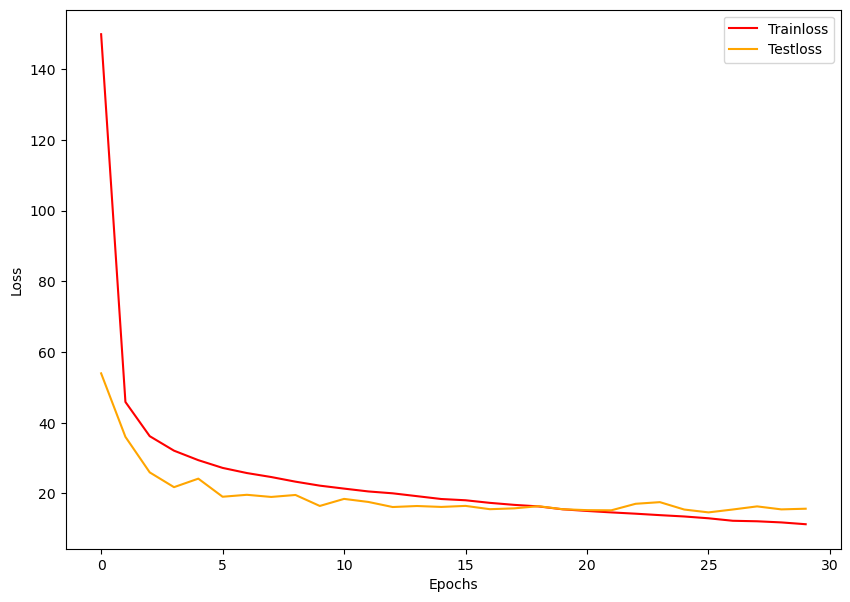

MyResNet_test2
Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:153.253136, Test Loss:48.266960, Train Acc:47.088%, Test Acc:85.187%
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:46.557797, Test Loss:32.974867, Train Acc:85.519%, Test Acc:89.870%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:36.288870, Test Loss:24.546203, Train Acc:88.936%, Test Acc:92.751%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:32.032690, Test Loss:22.192799, Train Acc:90.226%, Test Acc:93.581%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:29.396338, Test Loss:21.386841, Train Acc:91.104%, Test Acc:93.865%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:27.139669, Test Loss:20.121530, Train Acc:91.911%, Test Acc:94.361%
	 Weight Saved
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]
	 Train Loss:25.680150, 

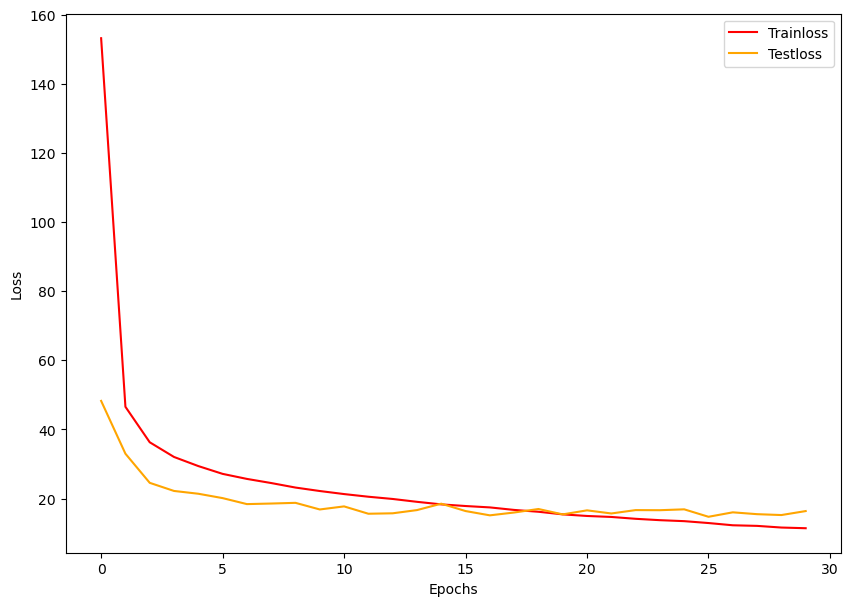

MyResNet_test3
Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:149.347039, Test Loss:56.677455, Train Acc:48.655%, Test Acc:82.629%
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:45.897177, Test Loss:31.448583, Train Acc:85.706%, Test Acc:90.492%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:36.229562, Test Loss:22.463509, Train Acc:88.894%, Test Acc:93.589%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:32.067942, Test Loss:22.630616, Train Acc:90.256%, Test Acc:93.485%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:29.532649, Test Loss:21.705053, Train Acc:90.973%, Test Acc:93.585%
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:27.320445, Test Loss:18.923462, Train Acc:91.767%, Test Acc:94.745%
	 Weight Saved
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]
	 Train Loss:2

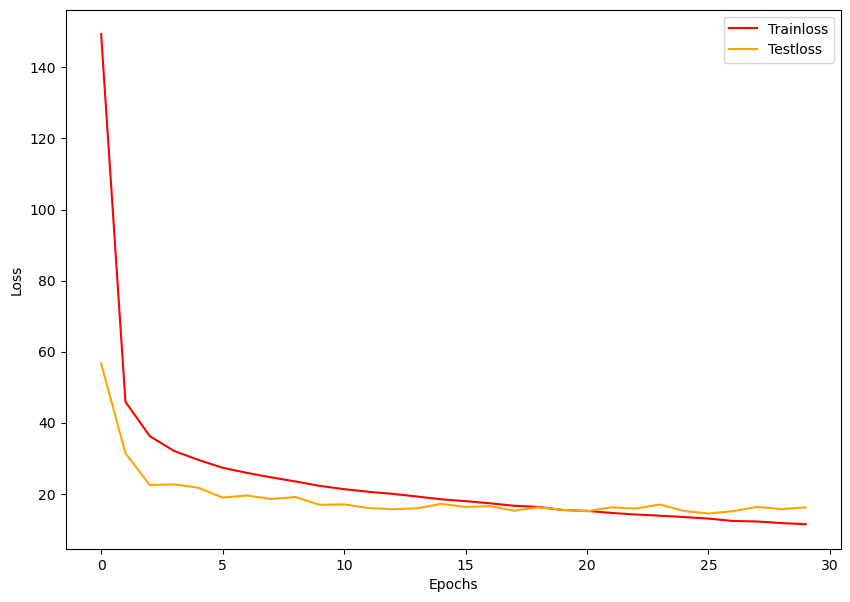

In [52]:
# 调小提前停止阈值，再进行三次训练，每次30个epochs

PATH = r"E:\data\SVHN\modelselect\ConfirmedResNet"

for modelname in ["MyResNet_test1", "MyResNet_test2", "MyResNet_test3"]:
    print(modelname)
    torch.manual_seed(1412)
    resnet18_ = m.resnet18()
    net = MyResNet().to(device, non_blocking=True)
    start = time()  # 计算训练时间
    trainloss, testloss = full_procedure(
        net, epochs=30, bs=256, modelname=modelname, PATH=PATH, tol=10**(-10))
    print(time()-start)
    plotloss(trainloss, testloss)

## Based new parameters training

myResNet_test0_1
Epoch1:[32000/1098855(3%)]
Epoch1:[64000/1098855(6%)]
	 Train Loss:153.210628, Test Loss:49.215091, Train Acc:47.212%, Test Acc:84.792%
Epoch2:[105257/1098855(10%)]
Epoch2:[137257/1098855(12%)]
	 Train Loss:46.235739, Test Loss:30.660994, Train Acc:85.732%, Test Acc:90.784%
	 Weight Saved
Epoch3:[178514/1098855(16%)]
Epoch3:[210514/1098855(19%)]
	 Train Loss:36.178464, Test Loss:22.813086, Train Acc:88.917%, Test Acc:93.431%
	 Weight Saved
Epoch4:[251771/1098855(23%)]
Epoch4:[283771/1098855(26%)]
	 Train Loss:31.962888, Test Loss:22.966200, Train Acc:90.185%, Test Acc:93.347%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/1098855(30%)]
Epoch5:[357028/1098855(32%)]
	 Train Loss:29.386495, Test Loss:21.311343, Train Acc:91.112%, Test Acc:93.831%
	 Weight Saved
Epoch6:[398285/1098855(36%)]
Epoch6:[430285/1098855(39%)]
	 Train Loss:27.146582, Test Loss:18.582072, Train Acc:91.851%, Test Acc:94.922%
	 Weight Saved
Epoch7:[471542/1098855(43%)]
Epoch7:[503542/1098855(

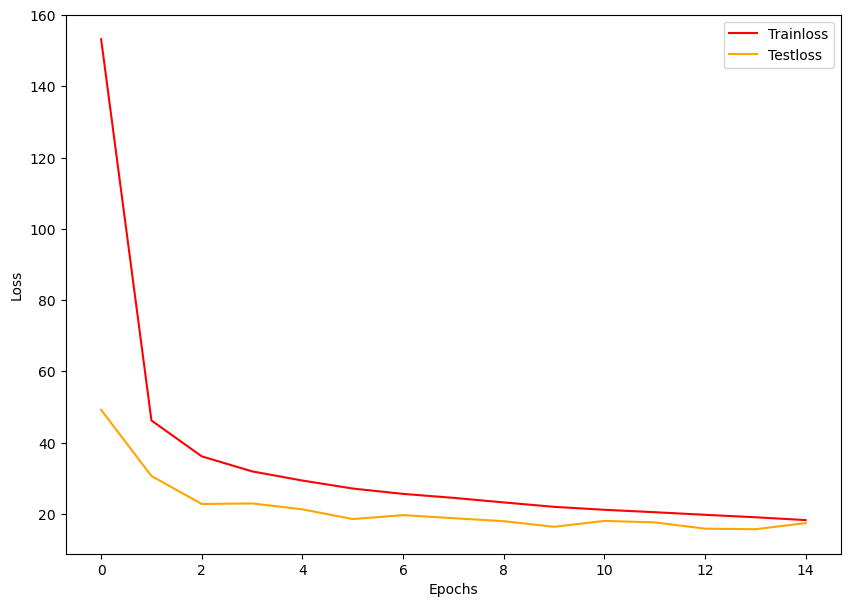

In [58]:
# 先按大lr进行初期迭代，再按小lr进行后期迭代
PATH = r"E:\data\SVHN\modelselect\ConfirmedResNet"
modelname = "myResNet_test0_1"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet().to(device, non_blocking=True)  # 完全重启，不借用任何过去训练好的参数
start = time()  # 计算训练时间
trainloss, testloss = full_procedure(net, epochs=15, bs=256, modelname=modelname, PATH=PATH, lr=0.001, tol=10**(-10)
                                     )
print(time()-start)
plotloss(trainloss, testloss)

MyResNet_retrain
Epoch1:[16000/2197710(1%)]
Epoch1:[32000/2197710(1%)]
Epoch1:[48000/2197710(2%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:16.229377, Test Loss:13.854142, Train Acc:95.303%, Test Acc:96.401%
Epoch2:[89257/2197710(4%)]
Epoch2:[105257/2197710(5%)]
Epoch2:[121257/2197710(6%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:15.118069, Test Loss:13.722088, Train Acc:95.718%, Test Acc:96.427%
	 Weight Saved
Epoch3:[162514/2197710(7%)]
Epoch3:[178514/2197710(8%)]
Epoch3:[194514/2197710(9%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:14.757919, Test Loss:13.617219, Train Acc:95.805%, Test Acc:96.404%
Epoch4:[235771/2197710(11%)]
Epoch4:[251771/2197710(11%)]
Epoch4:[267771/2197710(12%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:14.252164, Test Loss:13.676270, Train Acc:96.003%, Test Acc:96.404%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[309028/2197710(14%)]
Epoch5:[325028/2197710(15%)]
Epoch5:[341028/2197710(16%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:13.847785, Test Loss:13.726

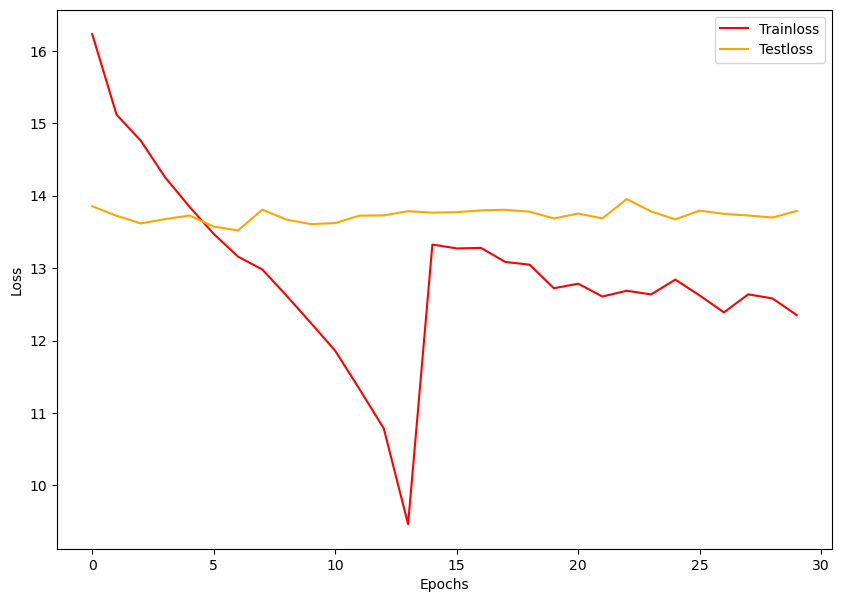

In [59]:
modelname = "MyResNet_retrain"

torch.manual_seed(1412)
resnet18_ = m.resnet18()
net.load_state_dict(torch.load(
    r"E:\data\SVHN\modelselect\ConfirmedResNet\myResNet_test0_1.pt"))

print(modelname)
torch.manual_seed(1412)
net = net.to(device, non_blocking=True)
start = time()  # 计算训练时间
trainloss, testloss = full_procedure(net, epochs=30, bs=128  # 令batch_size下降一半
                                     , modelname=modelname, PATH=PATH, lr=0.00001, gamma=0.0001, tol=10**(-10), wd=0.00005)  # wd非常敏感，因此要小心地进行调整
print(time()-start)
plotloss(trainloss, testloss)

## Update Model

### redefine model

In [60]:
class MyResNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False), resnet18_.bn1, resnet18_.relu)

        self.block2 = resnet18_.layer2
        self.block3 = resnet18_.layer3
        self.block4 = resnet18_.layer4  # 其他地方都不变，但增加原始残差网络中的layer4
        self.avgpool = resnet18_.avgpool
        self.fc = nn.Linear(in_features=512, out_features=10, bias=True)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], 512)  # 512个输出
        x = self.fc(x)
        return x


torch.manual_seed(1412)
resnet18_ = m.resnet18()
net2 = MyResNet2()

summary(net2, (10, 3, 28, 28), depth=2, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet2                                [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─Sequential: 1-4                        [10, 512, 4, 4]           --
│    └─BasicBlock: 2-8                   [10, 512, 4, 4]   

### Iterate on the new architecture by large lr first, then by small lr

MyResNet2_test1
Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:153.147112, Test Loss:47.148284, Train Acc:47.677%, Test Acc:85.322%
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:46.598148, Test Loss:30.768072, Train Acc:85.322%, Test Acc:90.631%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:36.946282, Test Loss:23.047821, Train Acc:88.606%, Test Acc:93.539%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:32.602581, Test Loss:21.548316, Train Acc:89.997%, Test Acc:93.896%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:30.107696, Test Loss:20.089305, Train Acc:90.846%, Test Acc:94.376%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:27.600279, Test Loss:21.085702, Train Acc:91.668%, Test Acc:94.253%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)

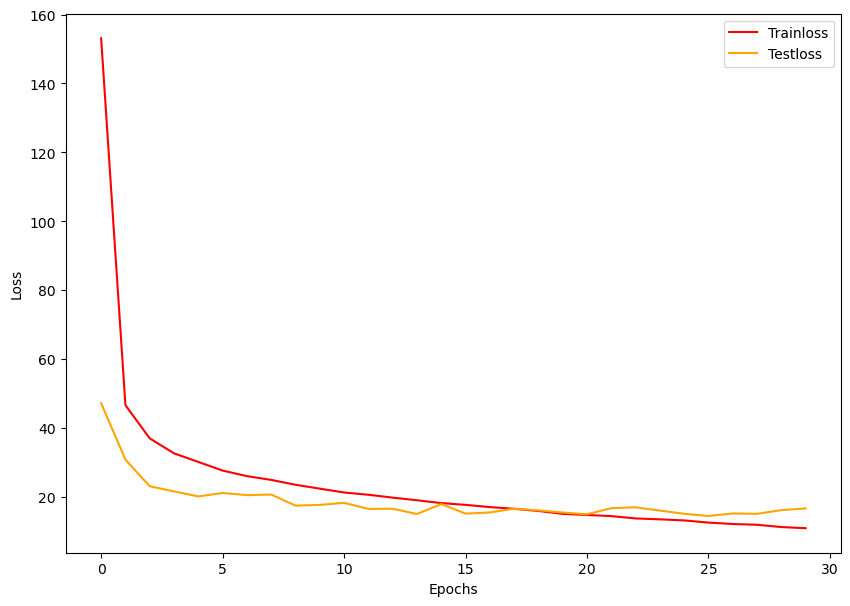

In [61]:
modelname = "MyResNet2_test1"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net2 = MyResNet2().to(device, non_blocking=True)
start = time()  # 计算训练时间
trainloss, testloss = full_procedure(
    net2, epochs=30, bs=256, modelname=modelname, PATH=PATH, tol=10**(-10))
print(time()-start)
plotloss(trainloss, testloss)

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:7.790161, Test Loss:14.023543, Train Acc:97.738%, Test Acc:96.512%
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:6.687998, Test Loss:14.488613, Train Acc:98.067%, Test Acc:96.435%
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:6.307936, Test Loss:14.674967, Train Acc:98.215%, Test Acc:96.389%
	 NOTICE: Early stopping counter 2 of 5
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:6.064383, Test Loss:14.598988, Train Acc:98.253%, Test Acc:96.547%
	 Weight Saved
	 NOTICE: Early stopping counter 3 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:5.612368, Test Loss:15.250778, Train Acc:98.354%, Test Acc:96.431%
	 NOTICE: Early stopping counter 4 of 5
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:5.223732, Test Loss:15.141587, Train Acc:98.441%, Test Acc:96.516%
	 NO

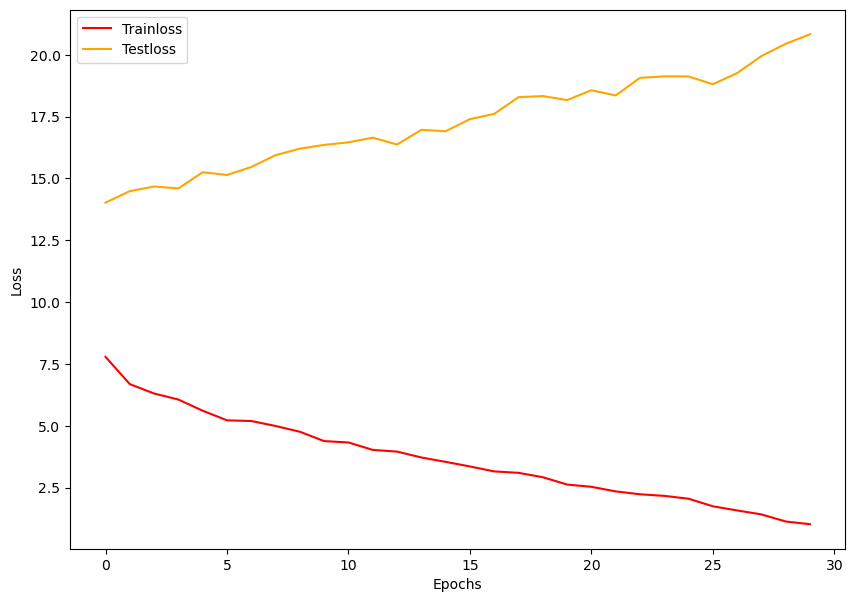

In [62]:
modelname = "MyResNet2_test2"

start = time()  # 计算训练时间
trainloss, testloss = full_procedure(
    net2, epochs=30, bs=256, modelname=modelname, PATH=PATH, tol=10**(-10), lr=0.0001)
print(time()-start)
plotloss(trainloss, testloss)